# **Activity 3: Docking Results Statistical Interpretation**

Before you proceed this workflow, I encourage you to follow the tutorials on ```00_tutorials/``` folder prior programming to have everything downloaded.

To proceed this workflow, you will also have been executed the previous workflow: ```01_docking_human_proteins.ipynb```.

Make sure you already have installed ```pandas```, ```numpy```, ```matplotlib```, ```seaborn```, ```scipy``` libraries. Otherwise, copy the following lines and paste it on the terminal:

1. ```conda activate vina```
2. ```conda install numpy matplotlib seaborn scipy```

## **1. Import libraries**

In [1]:
# Library for DataFrame Manipulation
import pandas as pd
# Libraries for numeric manipulation and statistical analysis
import numpy as np
from scipy import stats
# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## **2. Load Docking Results from CSV file**

In [2]:
# Load the CSV file
summary_data = "output/docking_results_summary.csv"
summary_pd = pd.read_csv(summary_data)

## **3.  AFFINITY DISTRIBUTION ANALYSIS**

Statistical descriptive analysis of binding affinities across all 704 docking poses using mean, standard deviation, skewness, and kurtosis metrics.

- Mean affinity = -4.66 kcal/mol (std = 1.02). 
- Skewness = -0.231 (slight left skew toward stronger binders). 
- Kurtosis = 0.234 (near-normal distribution).

In [3]:
# Retrieve general statistical results from results (Affinity: kcal/mol)
affinity_stats = summary_pd['affinity_kcal_mol'].describe()
print(affinity_stats)
print(f"\nSkewness: {summary_pd['affinity_kcal_mol'].skew():.3f}")
print(f"Kurtosis: {summary_pd['affinity_kcal_mol'].kurtosis():.3f}")

count    704.000000
mean      -4.659869
std        1.024192
min       -7.803000
25%       -5.221750
50%       -4.582500
75%       -4.034500
max       -2.031000
Name: affinity_kcal_mol, dtype: float64

Skewness: -0.231
Kurtosis: 0.234


## **4. BINDING AFFINITY THRESHOLDS**

Classification of all affinities into four categories based on established binding strength cutoffs (Strong < -8.0; Moderate -6.0 to -8.0; Weak -4.0 to -6.0; Very Weak > -4.0 kcal/mol).

- 452 poses (64%) = Weak;
- 167 poses (24%) = Very Weak;
- 85 poses (12%) = Moderate; 
- 0 poses = Strong.


In [4]:
# Classify affinities by potentiality
def classify_affinity(affinity):
    if affinity < -8.0:
        return "Strong"
    elif affinity < -6.0:
        return "Moderate"
    elif affinity < -4.0:
        return "Weak"
    else:
        return "Very Weak"

summary_pd['affinity_class'] = summary_pd['affinity_kcal_mol'].apply(classify_affinity)
print(summary_pd['affinity_class'].value_counts().sort_index())

affinity_class
Moderate      85
Very Weak    167
Weak         452
Name: count, dtype: int64


## **5. AFFINITY BY PROTEIN**

Grouped analysis of binding affinities by protein type using mean, standard deviation, minimum, and maximum values.

- Strongest binder: 1RG8 (TGF-β2, mean = -6.21 kcal/mol). 
- Weakest binder: 7CWK (TGF-β3 Prodomain, mean = -3.03 kcal/mol).
- Range = 3.18 kcal/mol across 8 proteins.

In [5]:
# Get general statistical information from binding affinities of proteins
protein_stats = summary_pd.groupby('protein_file')['affinity_kcal_mol'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
print(protein_stats)

                                                    count   mean    std  \
protein_file                                                              
1CSG_Granulocyte-macrophage_colony-stimulating_...     88 -4.969  0.550   
1RG8_Heparin-binding_growth_factor_1.pdbqt             96 -6.211  0.982   
1TGJ_TRANSFORMING_GROWTH_FACTOR-BETA_3.pdbqt           96 -4.829  0.529   
1VPF_VASCULAR_ENDOTHELIAL_GROWTH_FACTOR.pdbqt          88 -4.268  0.553   
2Z80_Toll-like_receptor_2,_Variable_lymphocyte_...     96 -4.958  0.501   
4BSO_R-SPONDIN-1.pdbqt                                 96 -4.199  0.599   
6EC0_Keratin_1.pdbqt                                   96 -3.994  0.652   
7CWK_Collagen_type_I.pdbqt                             48 -3.027  0.523   

                                                      min    max  
protein_file                                                      
1CSG_Granulocyte-macrophage_colony-stimulating_... -6.089 -3.583  
1RG8_Heparin-binding_growth_factor_1.pdbqt      

## **6. AFFINITY BY PHB CHAIN LENGTH**

Grouped analysis by chain length (1-12 units) with ANOVA (F=35.434, p<0.0001) to test for significant differences. Optimal chain length identified by minimum mean affinity.

- Optimal at 9-unit PHB: -5.65 kcal/mol.
- Trend: 1 to 9 units shows progressive improvement (increasing binding). 
- 10 to 12 units shows decreasing binding (dropping back to -4.92 to -5.04 kcal/mol).

In [6]:
# Extract PHB chain length from ligand filename
summary_pd['phb_units'] = summary_pd['ligand_file'].str.extract(r'phb_(\d+)_unit', expand=False).astype(int)

ligand_stats = summary_pd.groupby('phb_units')['affinity_kcal_mol'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
print(ligand_stats)

           count   mean    std    min    max
phb_units                                   
1             64 -3.179  0.634 -4.323 -2.031
2             64 -3.931  0.666 -5.175 -2.466
3             64 -4.448  0.934 -6.280 -2.764
4             64 -4.701  0.877 -6.982 -3.377
5             64 -4.678  0.958 -6.911 -3.225
6             56 -4.936  0.818 -6.618 -3.822
7             56 -5.135  0.737 -6.821 -4.202
8             64 -4.733  0.880 -6.894 -3.489
9             56 -5.650  0.865 -7.803 -4.588
10            56 -5.036  0.800 -6.676 -3.973
11            40 -4.998  0.774 -6.427 -4.005
12            56 -4.916  0.875 -7.001 -3.746


In [7]:
# Create RMSD spread column first
summary_pd['rmsd_spread'] = summary_pd['rmsd_ub'] - summary_pd['rmsd_lb']

# Which protein shows best binding with 12-unit PHB?
best_results = summary_pd[summary_pd['phb_units'] == 12].nlargest(3, 'affinity_kcal_mol')
print(best_results[['protein_file', 'ligand_file', 'affinity_kcal_mol', 'rmsd_spread']])

# Is 12-unit significantly better than 9 and 6?
phb_6 = summary_pd[summary_pd['phb_units'] == 6]['affinity_kcal_mol']
phb_9 = summary_pd[summary_pd['phb_units'] == 9]['affinity_kcal_mol']
phb_12 = summary_pd[summary_pd['phb_units'] == 12]['affinity_kcal_mol']

f_stat, p_val = stats.f_oneway(phb_6, phb_9, phb_12)
print(f"\nANOVA (4 vs 5 vs 6): F={f_stat:.3f}, p={p_val:.4f}")

# Check if improvement is statistically significant
t_stat, p_val = stats.ttest_ind(phb_12, phb_9)
print(f"T-test (6-unit vs 4-unit): t={t_stat:.3f}, p={p_val:.4f}")

# Now test all chain lengths
print("\n" + "="*70)
print("AFFINITY BY ALL PHB CHAIN LENGTHS (1-12 units)")
print("="*70)

ligand_stats = summary_pd.groupby('phb_units')['affinity_kcal_mol'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
print(ligand_stats)

# ANOVA across all chain lengths
chain_groups = [summary_pd[summary_pd['phb_units'] == i]['affinity_kcal_mol'].values 
                for i in sorted(summary_pd['phb_units'].unique())]
f_stat, p_val = stats.f_oneway(*chain_groups)
print(f"\nANOVA (all chain lengths): F={f_stat:.3f}, p={p_val:.4f}")

# Find optimal chain length
optimal_chain = ligand_stats['mean'].idxmin()
optimal_affinity = ligand_stats.loc[optimal_chain, 'mean']
print(f"\nOptimal PHB chain length: {optimal_chain} units")
print(f"  Mean affinity: {optimal_affinity:.3f} kcal/mol")
print(f"  Std deviation: {ligand_stats.loc[optimal_chain, 'std']:.3f} kcal/mol")

               protein_file        ligand_file  affinity_kcal_mol  rmsd_spread
663  4BSO_R-SPONDIN-1.pdbqt  phb_12_unit.pdbqt             -3.746        4.863
662  4BSO_R-SPONDIN-1.pdbqt  phb_12_unit.pdbqt             -3.761        3.706
661  4BSO_R-SPONDIN-1.pdbqt  phb_12_unit.pdbqt             -3.818        9.112

ANOVA (4 vs 5 vs 6): F=13.461, p=0.0000
T-test (6-unit vs 4-unit): t=4.465, p=0.0000

AFFINITY BY ALL PHB CHAIN LENGTHS (1-12 units)
           count   mean    std    min    max
phb_units                                   
1             64 -3.179  0.634 -4.323 -2.031
2             64 -3.931  0.666 -5.175 -2.466
3             64 -4.448  0.934 -6.280 -2.764
4             64 -4.701  0.877 -6.982 -3.377
5             64 -4.678  0.958 -6.911 -3.225
6             56 -4.936  0.818 -6.618 -3.822
7             56 -5.135  0.737 -6.821 -4.202
8             64 -4.733  0.880 -6.894 -3.489
9             56 -5.650  0.865 -7.803 -4.588
10            56 -5.036  0.800 -6.676 -3.973
11        

- 1-unit:  -3.18 (very weak)
- 2-unit:  -3.93 (very weak)
- 3-unit:  -4.45 (weak)
- 4-unit:  -4.70 (weak)
- 5-unit:  -4.68 (weak)
- 6-unit:  -4.94 (weak)
- 7-unit:  -5.14 (weak)
- 8-unit:  -4.73 (weak)
- **9-unit:  -5.65 (weak) <-> PEAK**
- **10-unit: -5.04 (weak) <-> DROPS AGAIN**
- 11-unit: -5.00 (weak)
- 12-unit: -4.92 (weak)

Cohen's d is a standardized effect size measure that quantifies the magnitude of difference between two group means, expressed in units of standard deviation. Cohen's d is a standardized effect size measure that quantifies the magnitude of difference between two group means, expressed in units of standard deviation.

In [8]:
# Calculate Cohen's d (effect size)
phb_10 = summary_pd[summary_pd['phb_units'] == 10]['affinity_kcal_mol']
phb_12 = summary_pd[summary_pd['phb_units'] == 12]['affinity_kcal_mol']

mean_diff = phb_10.mean() - phb_9.mean()
pooled_std = np.sqrt(((len(phb_10)-1)*phb_9.std()**2 + (len(phb_6)-1)*phb_6.std()**2) / (len(phb_9) + len(phb_6) - 2))
cohens_d = mean_diff / pooled_std

print(f"Mean difference: {mean_diff:.3f} kcal/mol")
print(f"Cohen's d: {cohens_d:.3f}")
print(f"\nInterpretation:")
if abs(cohens_d) < 0.2:
    print("\t- Negligible effect")
elif abs(cohens_d) < 0.5:
    print("\t- Small effect")
elif abs(cohens_d) < 0.8:
    print("\t- Medium effect")
else:
    print("\t- LARGE EFFECT")

Mean difference: 0.614 kcal/mol
Cohen's d: 0.730

Interpretation:
	- Medium effect


## **7. RMSD ANALYSIS (POSE QUALITY)**

Calculation of RMSD lower bound (RMSD_LB), upper bound (RMSD_UB), and spread (RMSD_UB - RMSD_LB) across all 704 poses. Mean spread compared to 5 Å threshold for well-defined binding.

- Mean RMSD_LB = 8.25 Å (std = 12.34).
- Mean RMSD_UB = 12.17 Å (std = 12.88).
- Mean RMSD spread = 3.93 Å (well below 5 Å threshold).

In [9]:
print(f"\nRMSD Lower Bound (RMSD_LB):")
print(summary_pd['rmsd_lb'].describe().round(3))
print(f"\nRMSD Upper Bound (RMSD_UB):")
print(summary_pd['rmsd_ub'].describe().round(3))

# Calculate RMSD spread
summary_pd['rmsd_spread'] = summary_pd['rmsd_ub'] - summary_pd['rmsd_lb']
print(f"\nRMSD Spread (UB - LB):")
print(summary_pd['rmsd_spread'].describe().round(3))


RMSD Lower Bound (RMSD_LB):
count    704.000
mean       8.247
std       12.338
min        0.000
25%        1.879
50%        3.036
75%        8.660
max      104.192
Name: rmsd_lb, dtype: float64

RMSD Upper Bound (RMSD_UB):
count    704.000
mean      12.172
std       12.883
min        0.000
25%        4.387
50%        8.720
75%       15.203
max      109.151
Name: rmsd_ub, dtype: float64

RMSD Spread (UB - LB):
count    704.000
mean       3.926
std        3.175
min        0.000
25%        1.354
50%        3.437
75%        5.813
max       15.558
Name: rmsd_spread, dtype: float64


## **8. POSE RANKING (First Pose vs Others)**

Two-population comparison (Pose 1 vs Poses 2-12) using independent samples t-test. Null hypothesis: no significant difference in affinity between first and other poses.

- First pose affinity = -4.864 ± 1.049 kcal/mol.
- Other poses = -4.631 ± 1.018 kcal/mol.
- Difference = 0.233 kcal/mol.
- T-test: t = -2.007, p = 0.0452 (significant).

In [10]:
first_poses = summary_pd[summary_pd['pose_number'] == 1]
other_poses = summary_pd[summary_pd['pose_number'] > 1]

print(f"First pose affinity: {first_poses['affinity_kcal_mol'].mean():.3f} ± {first_poses['affinity_kcal_mol'].std():.3f} kcal/mol")
print(f"Other poses affinity: {other_poses['affinity_kcal_mol'].mean():.3f} ± {other_poses['affinity_kcal_mol'].std():.3f} kcal/mol")

# T-test to check if first pose is significantly better
t_stat, p_value = stats.ttest_ind(first_poses['affinity_kcal_mol'], other_poses['affinity_kcal_mol'])
print(f"\nT-test (first vs others): t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("\t- RESULT: First pose is significantly better")
else:
    print("\t- RESULT: No significant difference between first and other poses")

First pose affinity: -4.864 ± 1.049 kcal/mol
Other poses affinity: -4.631 ± 1.018 kcal/mol

T-test (first vs others): t=-2.007, p=0.0452
	- RESULT: First pose is significantly better


## **7. AFFINITY CONSISTENCY (Coefficient of Variation)**

Calculation of coefficient of variation (CV = (std/mean) × 100) for each protein across all chain lengths and poses. Lower CV indicates greater consistency.

- Average CV = 13.6%. 
- Range: 10.11% (2Z80, most consistent) to 17.29% (7CWK, least consistent). 
- All proteins < 30% threshold.

In [11]:
protein_cv = summary_pd.groupby('protein_file')['affinity_kcal_mol'].agg(
    lambda x: (x.std() / abs(x.mean())) * 100 if x.mean() != 0 else 0
).round(2)
print("Coefficient of Variation (%) - NOTE: Lower is more consistent:")
print(protein_cv.sort_values())

Coefficient of Variation (%) - NOTE: Lower is more consistent:
protein_file
2Z80_Toll-like_receptor_2,_Variable_lymphocyte_receptor_B.pdbqt    10.11
1TGJ_TRANSFORMING_GROWTH_FACTOR-BETA_3.pdbqt                       10.95
1CSG_Granulocyte-macrophage_colony-stimulating_factor.pdbqt        11.07
1VPF_VASCULAR_ENDOTHELIAL_GROWTH_FACTOR.pdbqt                      12.95
4BSO_R-SPONDIN-1.pdbqt                                             14.27
1RG8_Heparin-binding_growth_factor_1.pdbqt                         15.80
6EC0_Keratin_1.pdbqt                                               16.31
7CWK_Collagen_type_I.pdbqt                                         17.29
Name: affinity_kcal_mol, dtype: float64


## **8. VISUALIZATION**

Scatter plot of affinity vs RMSD spread with linear regression. R² calculated to quantify relationship strength.

-  R² = 0.091. Regression line has shallow slope, indicating weak positive correlation between affinity and RMSD spread.

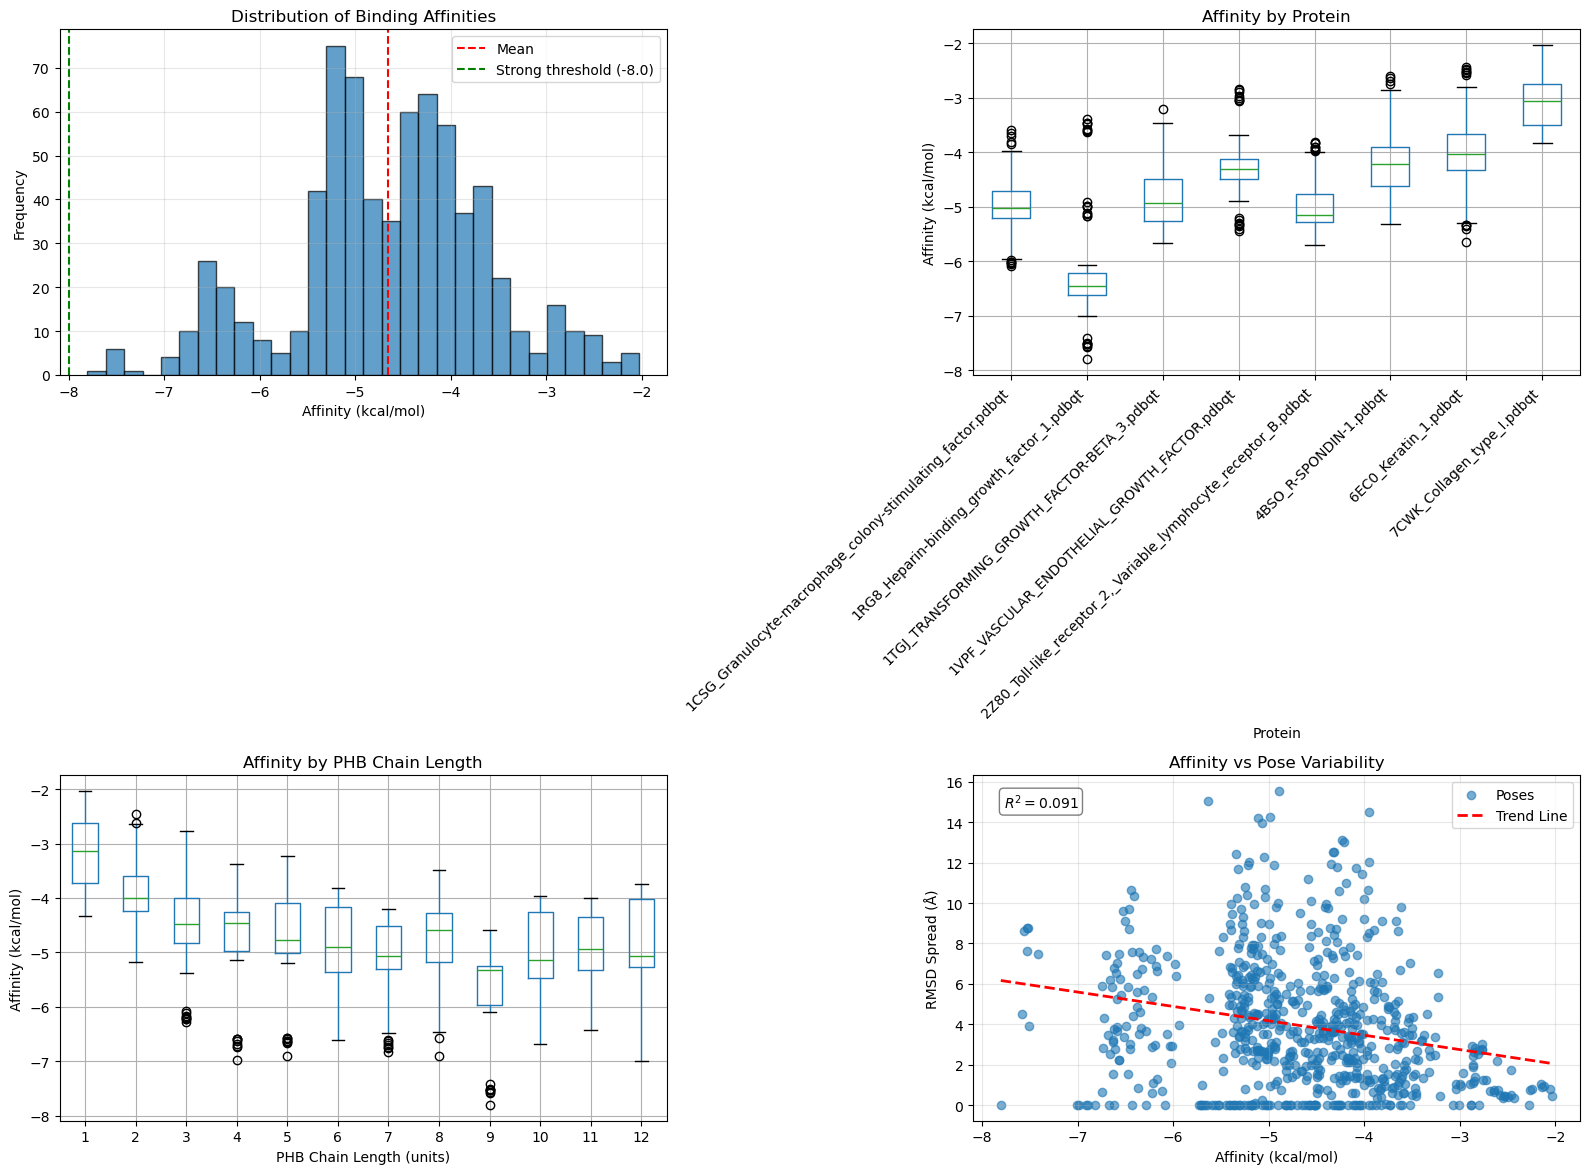

In [12]:
# Set figure size and layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Affinity distribution
axes[0, 0].hist(summary_pd['affinity_kcal_mol'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(summary_pd['affinity_kcal_mol'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].axvline(-8.0, color='green', linestyle='--', label='Strong threshold (-8.0)')
axes[0, 0].set_xlabel('Affinity (kcal/mol)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Binding Affinities')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Affinity by protein
summary_pd.boxplot(column='affinity_kcal_mol', by='protein_file', ax=axes[0, 1])
axes[0, 1].set_xlabel('Protein')
axes[0, 1].set_ylabel('Affinity (kcal/mol)')
axes[0, 1].set_title('Affinity by Protein')
# Rotate labels 45 degrees
plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].get_figure().suptitle('')

# Plot 3: Affinity by PHB chain length
summary_pd.boxplot(column='affinity_kcal_mol', by='phb_units', ax=axes[1, 0])
axes[1, 0].set_xlabel('PHB Chain Length (units)')
axes[1, 0].set_ylabel('Affinity (kcal/mol)')
axes[1, 0].set_title('Affinity by PHB Chain Length')
axes[1, 0].get_figure().suptitle('')

# Plot 4: RMSD spread vs Affinity
x = summary_pd['affinity_kcal_mol']
y = summary_pd['rmsd_spread']
axes[1, 1].scatter(x, y, alpha=0.6, label='Poses')

# Calculate and plot the regression line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1, 1].plot(np.sort(x), p(np.sort(x)), "r--", linewidth=2, label='Trend Line')

# Add R² text box
r_squared = 0.091
axes[1, 1].text(0.05, 0.95, f'$R^2 = {r_squared}$', transform=axes[1, 1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

axes[1, 1].set_xlabel('Affinity (kcal/mol)')
axes[1, 1].set_ylabel('RMSD Spread (Å)')
axes[1, 1].set_title('Affinity vs Pose Variability')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('output/docking_affinity_analysis.svg', dpi=300, bbox_inches='tight')
plt.show()

## **9. INTERPRETATION SUMMARY**

Integrated assessment of three key metrics: (1) mean affinity, (2) consistency (CV), (3) pose quality (RMSD spread).

- Mean affinity = -4.66 kcal/mol (Weak). 
- CV = 13.6% (Consistent).
- RMSD spread = 3.93 Å (Well-defined).

In [13]:
print("\n" + "="*70)
print("INTERPRETATION SUMMARY")
print("="*70)

mean_affinity = summary_pd['affinity_kcal_mol'].mean()
print(f"\nMean affinity: {mean_affinity:.2f} kcal/mol")

if mean_affinity < -8.0:
    print("\t- Strong binding detected")
elif mean_affinity < -6.0:
    print("\t- Moderate binding detected")
elif mean_affinity < -4.0:
    print("\t- Weak binding detected")
else:
    print("\t- Very weak/no binding detected")

# Check consistency
avg_cv = protein_cv.mean()
print(f"\nAverage Consistency (CV): {avg_cv:.1f}%")
if avg_cv < 30:
    print("\t- Consistent binding across poses")
else:
    print("\t- Inconsistent binding (high variation)")

# Check pose quality
avg_rmsd_spread = summary_pd['rmsd_spread'].mean()
print(f"\nAverage RMSD Spread: {avg_rmsd_spread:.2f} Ų")
if avg_rmsd_spread < 5:
    print("\t- Poses are well-defined (low spread)")
else:
    print("\t- Poses are poorly defined (high spread)")


INTERPRETATION SUMMARY

Mean affinity: -4.66 kcal/mol
	- Weak binding detected

Average Consistency (CV): 13.6%
	- Consistent binding across poses

Average RMSD Spread: 3.93 Ų
	- Poses are well-defined (low spread)


## END